In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import gensim

# More NLP

## Truncated Singular Value Decomposition and Dimensionality Reduction

When processing text we end up with feature sets that are large! There is up to one feature per different word in our text sample, far larger than a typical feature set that we're used to. One thing we can do when vectorizing is just to cap the number of features we end up with, but that doesn't seem to be the most sophisticated approach. 

TSVD is one thing that we can do to chop down the feature set - or reduce the dimensions - with a little more thought. 

## Dimensionality Reduction

Dimensionality reduction is a common technique in machine learning, it does its name - reduces the dimensions in our feature data. 

#### Load Dataset from Last Time

In [22]:
#Load Data
df = pd.read_csv("data/spam.csv", encoding="ISO-8859-1")
df.drop(columns={"Unnamed: 2", "Unnamed: 3", "Unnamed: 4"}, inplace=True)
df.rename(columns={"v1":"target", "v2":"text"}, inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
#TF-IDF
vec_tf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,4), stop_words="english", strip_accents="unicode")
tmp = vec_tf.fit_transform(df["text"])
tok_cols = vec_tf.get_feature_names()
tok_df = pd.DataFrame(tmp.toarray(), columns=tok_cols)
print("original:", df["text"].shape)
print("vectorized:", tmp.shape)
y = df["target"]
X = df["text"]
tok_df.sample(5)

original: (5572,)
vectorized: (5572, 89635)


,00,00 easter,00 easter prize,00 easter prize draw,00 sub,00 sub 16,00 sub 16 remove,00 sub 16 unsub,00 subs,00 subs 16,...,zoom cine actually,zoom cine actually tonight,zouk,zouk nichols,zouk nichols paris,zouk nichols paris free,zyada,zyada kisi,zyada kisi ko,zyada kisi ko kuch
422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## LSA - Latent Semantic Analysis

The TSVD performs somehting called latent semantic analysis. The process of LSA and the math behind it are not something we need to explore in detail. (LSA is often called LSI - Latent Semantic Indexing)

The idea of LSA is that it can generate "concepts" in the text. These concepts are found by looking at which terms occur in which documents - documents that have the same terms repeated are likely related to the same concept; other documents that share other words with those documents are likely on the same concept as well.  

An important part is the word "Latent" - i.e. the patterns detected are hidden, not explicit in the data. 

#### Implement SVD to Trim Dataset

We are starting with LOTS of feature inputs. Below we can loop through several models of different number of remaining components to see the accuracy depending on the number of features we keep in the feature set. 

The truncated part of truncated SVD trims the featureset down to the most significant features. 

We started with a lot of features - we can make predictions that are close to as accurate with far fewer, hopefully!

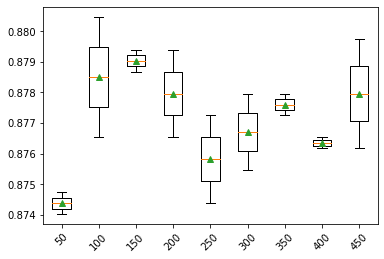

In [4]:
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,10):
		n = i*50
		steps = [('svd', TruncatedSVD(n_components=n)), ('m', LogisticRegression())]
		models[str(n)] = Pipeline(steps=steps)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	#Splits cut for speed
	cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, tok_df, y)
	results.append(scores)
	names.append(name)
# plot model performance for comparison

plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

### Exercise - Truncated SVD

Try to use the same text for predictions from the newsgroups last time. Try to use the TSVD with a limited number of components and see if the accuracy can stay similar to what we got last time. 

In [5]:
from sklearn.datasets import fetch_20newsgroups
remove = ("headers", "footers", "quotes")
categories = ["alt.atheism", "talk.religion.misc"]

data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42, remove=remove)

data_test = fetch_20newsgroups(
    subset="test", categories=categories, shuffle=True, random_state=42, remove=remove)

In [6]:
# Vectorize and prep datasets
news_tf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,4), stop_words="english", strip_accents="unicode")
X_train = news_tf.fit_transform(data_train.data)
y_train = data_train.target
X_test = news_tf.transform(data_test.data)
y_test = data_test.target
print("Train (x,y):", X_train.shape, "  Test (x,y):", X_test.shape)

Train (x,y): (857, 226373)   Test (x,y): (570, 226373)


In [7]:
# Create Models
tsvd = TruncatedSVD(n_components=50)
news_steps = [('svd', tsvd), ('m', LogisticRegression())]
news_model = Pipeline(steps=news_steps)
news_model.fit(X_train, y_train)
news_model.score(X_test, y_test)

0.6210526315789474

In [8]:
terms = news_tf.get_feature_names()
for index, component in enumerate(tsvd.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['ico', 'ico tek', 'ico tek com', 'vice ico', 'vice ico tek']
Topic 1:  ['just', 'god', 'people', 'don', 'think']
Topic 2:  ['cobb', '3rd debate', '3rd debate cobb', '3rd debate cobb alexia', 'champaign urbana']
Topic 3:  ['mom', 'men', 'isc', 'isc rit', 'isc rit edu']
Topic 4:  ['freewill', 'angels freewill', 'angels freewill god', 'angels freewill god tells', 'freewill god']
Topic 5:  ['deletion', 'atheism', 'exist', 'definition', 'alt atheism']
Topic 6:  ['deletion', 'ra', 'mcconkie', 'mormon', 'lds']
Topic 7:  ['start', 'just', 'deletion', 'hand', 'account smile']
Topic 8:  ['context', 'quote context', 'quotes context', 'jim', 'quote']
Topic 9:  ['messenger', 'koresh', 'carried says', 'carried says character', 'carried says character messenger']
Topic 10:  ['washed', 'washed blood', 'bull', 'blood', 'lamb']
Topic 11:  ['rb', 'young', 'preying', 'preying young', 'altar boy']
Topic 12:  ['said surrender', 'surrender', 'didn', 'broadcast message', 'broadcast message didn']
T

## Word2Vec and Classification

In addition to calculating things solely directly from our data, we can also use some external tools that can help create embeddings that are a little better (hopefully). This is also a neural network running behind the scenes to help us out. 

Word2Vec is an algorithm made by Google that can help process text and produce embeddings. Word2Vec looks for associations of words that occur with each other. 

### Word2Vec in Process

Word2Vec generates its embeddings by looking at words in a sentence, and the surrounding words in that same sentence. 

### Gensim

Gensim is a package that we can install that has an implementation of Word2Vec that we can use pretty easily. 

In [9]:
from gensim.models import Word2Vec
import nltk
for package in ['stopwords','punkt','wordnet']:
    nltk.download(package) 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
stop_words    = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\allyr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\allyr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\allyr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Tokenizer

Since we are not using the vecorizer from sklearn, we need to provide our own tokenization. We can use the nltk based one from last time. 

We can also do any other types of processing here that we may want - stemming, customized stop words, etc... For this one I chopped out any 1 character tokens and added a regex filter to get rid of punctuation. 

In [10]:
class lemmaTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import WordNetLemmatizer
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                tok = re.sub('\W+','', tok) #Punctuation strip
                tmp = self.lemmatizer.lemmatize(tok)
                if len(tmp) >= 2:
                    filtered_tok.append(tmp)
        return filtered_tok

### Create Clan Text - Tokenize and Lemmatize

Prep some data. The "second half" of the dataframe is what we can use with the Word2Vec prediction models - we have cleaned up lists of tokens as well as translating the targets to 1 and 0. 

In [11]:
tok = lemmaTokenizer(stop_words)
df["clean_text"] = df["text"].apply(lambda x: tok(x))
df["target2"] = pd.get_dummies(df["target"], drop_first=True)
df.head()

,target,text,clean_text,target2
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, jurong, point, crazy, Available, bugis, g...",0
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, Joking, wif, oni]",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, wkly, comp, win, FA, Cup, final,...",1
3,ham,U dun say so early hor... U c already then say...,"[dun, say, early, hor, already, say]",0
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, nt, think, go, usf, life, around, though]",0


### Create Word2Vec

We can train our Word2Vec model with our cleaned up data. This will have Word2Vec do its magic behind the scenes and perform the training. W2V works in one of two ways, which are roughly opposites of each other, when doing this training:
<ul>
<li> Continuous Bag of Words: looks at a window around each target word to try to predict surrounding words.
<li> Skip-Gram: looks at words surrounding target to try to predict it. 
</ul>

We'll revisit the details of this stuff later on when we look at neural networks, since W2V is a neural network algorithm, it will make more sense in context. 

Note: this training is not making a model that we are using to make predictions. This is training inside the W2V algorithm to generate representations of our tokens. 

In [12]:
# create Word2vec model
model = Word2Vec(df['clean_text'],min_count=1, vector_size=200, sg=1)
#min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it

#combination of word and its vector
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

### Word2Vec Model

Each word in the vocabulary now has a vector representing it - of size 200. We can make a dataframe and see each token in our text and its vector representation. This vector is the internal representation of each token that is generated by Word2Vec. This is how the algorithm calculates things like similarity...

In [13]:
tmp = pd.DataFrame(w2v)
vectors = model.wv
tmp.head()

,call,nt,get,gt,lt,ur,You,go,know,like,...,ARR,oscar,Open,rebtel,firefox,Married,MATCH,69969,BCMSFWC1N3XX,stereo
0,0.116375,0.156792,0.158708,0.321951,0.216616,0.174367,0.147904,0.150828,0.155467,0.182896,...,0.009647,0.005592,0.011770,0.015851,0.016621,0.004652,0.022397,0.012988,0.007995,0.005745
1,-0.095507,-0.040269,-0.062688,0.061272,0.097082,-0.140898,-0.091136,-0.032011,-0.065905,-0.040247,...,-0.004123,-0.009674,-0.007568,-0.006583,-0.009276,-0.004077,-0.016532,-0.017853,-0.008014,-0.007406
2,0.044570,-0.063693,-0.039536,-0.093271,-0.085041,-0.001040,-0.016362,-0.051052,-0.034060,-0.060825,...,-0.005055,0.004554,-0.002711,0.002373,-0.000186,0.001902,0.000385,0.000360,0.001871,0.002694
3,0.148492,0.069820,0.094406,0.285376,0.336813,0.042543,0.057299,0.042044,0.074621,0.093745,...,0.001577,0.005782,0.000237,0.008893,-0.000488,-0.000517,0.003145,0.006734,0.004426,0.000357
4,0.299841,0.257111,0.272470,0.316804,0.376421,0.247741,0.264024,0.225980,0.264229,0.246018,...,0.010832,0.012647,0.015564,0.019469,0.022157,0.012113,0.028493,0.031961,0.017540,0.012898


### Similarity

One of the things that Word2Vec allows us to do is to look at the similarity of words. This similarity is calculated via the cosine distance of the vectors. Cosine similarity is a technique to calculate the distance between two vectors - smaller distance, more similar. 

![Cosine Similarity](images/cosine_sim.png "Cosine Similarity" )

Once the vectors are derived by in the training process, these similarity calculations are pretty easy and quick. 

Note: the similarites here are calculated by the values derived from our trained model. So they are based on the relationships in our text. Word2Vec and other NLP packages also commonly have pretrained models that can be downloaded that are based on large amounts of text. Words may be represented very differently in those vs whatever we train here - the more data we have, the more consistent they'll be; the more "unique" our text is, the more different it will be. 

In [14]:
#Find the most similar word to anything in our vocabulary 
vectors.most_similar("think")[0:3]

[('would', 0.9985832571983337),
 ('thing', 0.9984398484230042),
 ('need', 0.9981087446212769)]

In [15]:
# We can also see how similar different words are. 
vectors.similarity("think", "determine")

0.9730587

### Make Predictions

We can take our actual data now and transform it through the Word2Vec model that we've made. This will generate our smaller feature set that we can build our models from.

One of the things that the MeanEmbeddingVectorizer does is to collapse the data down to those 200 dimensions in the vector. 

In [16]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Split data - using the new dataframe parts that we cleaned up. 
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"],df["target2"])

#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train)
X_test_vectors_w2v = modelw.transform(X_test)
X_train_vectors_w2v.shape

(4179, 200)

#### Build Model

We can now use the new data to make predictions. 

In [17]:
# Make predictions
lr_w2v = RandomForestClassifier()
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]
 

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1205
           1       0.93      0.83      0.88       188

    accuracy                           0.97      1393
   macro avg       0.95      0.91      0.93      1393
weighted avg       0.97      0.97      0.97      1393

Confusion Matrix: [[1193   12]
 [  32  156]]
AUC: 0.9765471881345458


### Exercise - Word2Vec

Use the newsgroup data and Word2Vec to make predictions. 

In [18]:
# Prepare datsets and Tokenize
tok = lemmaTokenizer(stop_words)
X_w2v_news_train = [tok(x) for x in data_train.data]
X_w2v_news_test = [tok(x) for x in data_test.data]

y_train_news = data_train.target
y_test_news = data_test.target

In [19]:
# create Word2vec model
model_news = Word2Vec(X_w2v_news_train, min_count=1, vector_size=200)
w2v_news = dict(zip(model_news.wv.index_to_key, model_news.wv.vectors)) 

In [20]:
#Word2vec
# Fit and transform
model_news_w = MeanEmbeddingVectorizer(w2v_news)
X_train_vectors_w2v_news = modelw.transform(X_w2v_news_train)
X_val_vectors_w2v_news = modelw.transform(X_w2v_news_test)
X_train_vectors_w2v.shape

(4179, 200)

In [21]:
# Make predictions
news_clf = RandomForestClassifier()
news_clf.fit(X_train_vectors_w2v_news, y_train_news)  #model

#Predict y value for test dataset
y_predict_news = news_clf.predict(X_val_vectors_w2v_news)
y_prob_news = news_clf.predict_proba(X_val_vectors_w2v_news)[:,1]
 

print(classification_report(y_test_news,y_predict_news))
print('Confusion Matrix:',confusion_matrix(y_test_news, y_predict_news))
 
fpr, tpr, thresholds = roc_curve(y_test_news, y_prob_news)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.55      0.64      0.59       319
           1       0.42      0.34      0.38       251

    accuracy                           0.51       570
   macro avg       0.49      0.49      0.48       570
weighted avg       0.50      0.51      0.50       570

Confusion Matrix: [[204 115]
 [166  85]]
AUC: 0.48400129887971627
